In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-09-18 15:52:25.526409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(f"tensorflow version: {tf.__version__} (make sure it's at least >= 2.0) ")

tensorflow version: 2.11.0 (make sure it's at least >= 2.0) 


# Generate some dummy 1D data

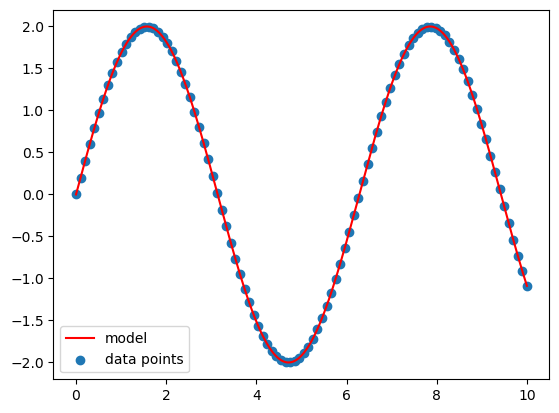

In [3]:
n_pts = 200
X = np.linspace(0, 10, 100)
Y = 2*np.sin(X)
plt.plot(np.linspace(0, 10, 2000), 2*np.sin(np.linspace(0, 10, 2000)), c='red', label='model')
plt.scatter(X, Y, marker='o', label='data points')
plt.legend()

and let's just add manually the channel dimension:

In [4]:
print('X shape before: ', X.shape)
print('Y shape before: ', X.shape)
X = np.expand_dims(X, -1)
Y = np.expand_dims(Y, -1)
print('X shape after: ', X.shape)
print('Y shape after: ', X.shape)

X shape before:  (100,)
Y shape before:  (100,)
X shape after:  (100, 1)
Y shape after:  (100, 1)


# Generate the tf.dataset from numpy arrays (my fav way to do it):

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((X, Y))

2023-09-18 15:52:32.436888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Using tf datasets is powerfull (and this is the way to go to do complex/heavy training), but it goes with some drawbacks, inherant to the method. As most of thensorflow architecture, it uses the idea of container, i.e. creating "empty" objects that would be really created and filled when you need it, i.e. in the flow of your training. Thus, for now our dataset is an 'empty' shell that you can't call very easily (but still much easier than when everything was static as in tensorflow 1...):

In [6]:
x = dataset[0]

In [7]:
dataset.shape

to test your dataset (which is always a good idea), you can use the `take` method, that will allow you access the `n` first elements of your dataset: 

In [8]:
n = 5
for i, (x, y) in enumerate(dataset.take(n)):
    print(f'x_{i} shape: ', x.shape, x)
    print(f'y_{i} shape: ', x.shape, y)
    # print(i, x, y)

x_0 shape:  (1,) tf.Tensor([0.], shape=(1,), dtype=float64)
y_0 shape:  (1,) tf.Tensor([0.], shape=(1,), dtype=float64)
x_1 shape:  (1,) tf.Tensor([0.1010101], shape=(1,), dtype=float64)
y_1 shape:  (1,) tf.Tensor([0.20167684], shape=(1,), dtype=float64)
x_2 shape:  (1,) tf.Tensor([0.2020202], shape=(1,), dtype=float64)
y_2 shape:  (1,) tf.Tensor([0.40129771], shape=(1,), dtype=float64)
x_3 shape:  (1,) tf.Tensor([0.3030303], shape=(1,), dtype=float64)
y_3 shape:  (1,) tf.Tensor([0.59682761], shape=(1,), dtype=float64)
x_4 shape:  (1,) tf.Tensor([0.4040404], shape=(1,), dtype=float64)
y_4 shape:  (1,) tf.Tensor([0.78627322], shape=(1,), dtype=float64)


You can see that your np arrays have already been transformed in tf.tensors, which is nice!

The shapes is `(1, )` meaning that it's a single data point with 1 channel (i.e. a scalar)

### Now, let's show why dataset is nice, even without talking about the efficiency of all the callings methods behing the API.
The dataset objects has a lot of methods that everybody want to use when you're creating ML datasets:
- `shuffle`:

In [9]:
dataset = dataset.shuffle(buffer_size=1000)

In [10]:
n = 10
xs = []
ys = []
for i, (x, y) in enumerate(dataset.take(n)):
    xs.append(x)
    ys.append(y)

And you can check that input and labels have been shuffled accordingly:

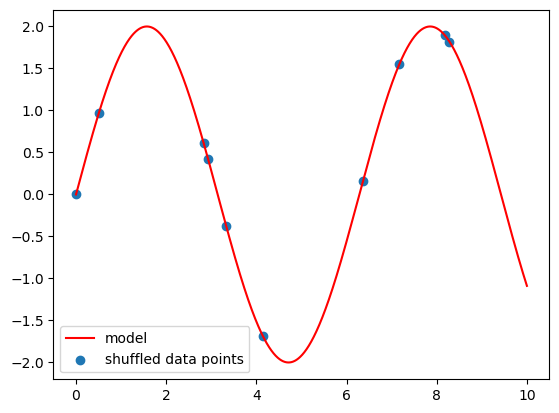

In [11]:
plt.plot(np.linspace(0, 10, 2000), 2*np.sin(np.linspace(0, 10, 2000)), c='red', label='model')
plt.scatter(xs, ys, marker='o', label='shuffled data points')
plt.legend()

- preprocessing with `map`:

### Careful
Note that if you want a global transformation (e.g. dividing by the max of all your dataset, you should do it before hand, i.e. in the numpy process)
Here it will apply the preprocessing to each individual datapoint. FOr example if you're working with images and you want all individual images to be normalised separaty.
In your 1D case, I'm not sure you need this. But this is powerful with higher dimension datasets.

In [12]:
def preprocess(x, y):
    ' apply your favorite preprocessing function here (this is dummy for a 1D example)'
    x -= 1
    y -= 1
    return x, y

In [13]:
dataset = dataset.map(preprocess)

In [14]:
n = 100
xs = []
ys = []
for i, (x, y) in enumerate(dataset.take(n)):
    xs.append(x)
    ys.append(y)

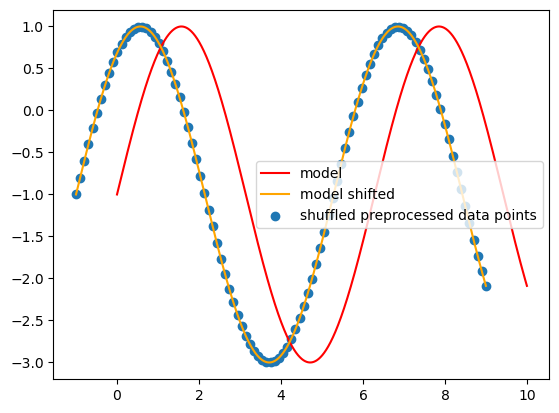

In [15]:

plt.plot(np.linspace(0, 10, 2000), 2*np.sin(np.linspace(0, 10, 2000))-1, c='red', label='model')
plt.plot(np.linspace(-1, 9, 2000), 2*np.sin(np.linspace(0, 10, 2000))-1, c='orange', label='model shifted')
plt.scatter(xs, ys, marker='o', label='shuffled preprocessed data points')
plt.legend()

- `batch`:

In [16]:
batch_size = 4
dataset = dataset.batch(batch_size)


In [17]:
n = 1
for i, (x, y) in enumerate(dataset.take(n)):
    print('x shape : ', x.shape, x)
    print('y shape : ', x.shape, y)


x shape :  (4, 1) tf.Tensor(
[[6.67676768]
 [5.46464646]
 [7.08080808]
 [2.23232323]], shape=(4, 1), dtype=float64)
y shape :  (4, 1) tf.Tensor(
[[ 0.96867732]
 [-0.63906614]
 [ 0.94876998]
 [-1.18121229]], shape=(4, 1), dtype=float64)


You can see that it indeed creating batches, changing the shape (from `(1, )`, i.e. scalar, to `(4, 1)`, i.e. batch of 4 scalars)

## All in one line !
Finally, what is nice is that when you get familiar with the API, your dataset creation can resume to (but at first be sure to understand each step):

In [18]:
dataset  = tf.data.Dataset.from_tensor_slices((X, Y)).shuffle(10000).map(preprocess).batch(batch_size=64)

And you will be able to use it directly in a training loop:

In [19]:
in_ = tf.keras.Input(shape=(1,))
y_0 = tf.keras.layers.Dense(16, activation='relu')(in_)
y_1 = tf.keras.layers.Dense(32, activation='relu')(y_0)
y_2 = tf.keras.layers.Dense(64, activation='relu')(y_1)
out_ = tf.keras.layers.Dense(1)(y_2)
dummy_model = tf.keras.Model(in_, out_)

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

for epoch in range(1000):
    for batch_x, batch_y in dataset:
        with tf.GradientTape() as tape:
            pred = dummy_model(batch_x)
            # print(pred.shape)
            loss = tf.keras.losses.MSE(pred, batch_y)
        gradients = tape.gradient(loss, dummy_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, dummy_model.trainable_variables))


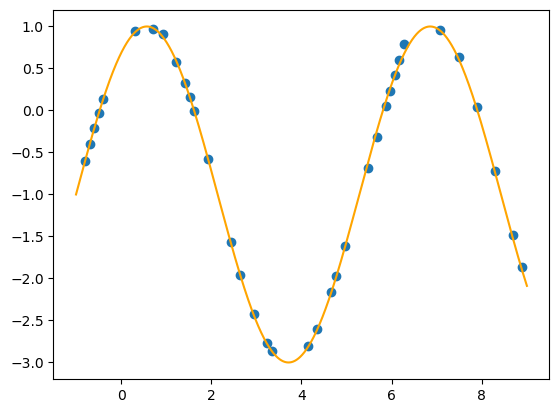

In [21]:
plt.scatter(batch_x, dummy_model(batch_x))
plt.plot(np.linspace(-1, 9, 2000), 2*np.sin(np.linspace(0, 10, 2000))-1, c='orange', label='model shifted')


### yay, working !